In [1]:
import kmeans_qaoa as kq
from qiskit import IBMQ
import numpy as np
import coreset
import networkx as nx
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit import execute
from qiskit.tools.monitor import job_monitor

In [2]:
provider = IBMQ.load_account()

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')

In [4]:
backends = provider.backends()
for b in backends: print(b)

ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_valencia
ibmq_london
ibmq_burlington
ibmq_johannesburg
ibmq_rochester
ibmq_essex
ibmq_armonk
ibmq_cambridge
ibmq_paris


In [6]:
shots = 8192
P = 1
qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
device = provider.get_backend('ibmq_rome')
noise_model = NoiseModel.from_backend(device)
basis_gates = device.configuration().basis_gates
coupling_map= device.configuration().coupling_map
props = device.properties()
#plot_gate_map(device)

In [7]:
coreset_vectors = np.load('pulsar_coreset_vectors.npy')
coreset_weights = np.load('pulsar_coreset_weights.npy')
for v, w in zip(coreset_vectors, coreset_weights):
    print(v,w)

[ 24.20128166  14.69255179  -0.45390471  -2.50806823 -10.60854682
 -12.77520754   1.85345051  29.7062432 ] 7290.557889102448
[-40.19715584  -5.19405635   1.18948133   2.32577153  -8.87694146
  -1.34954267  -1.06196487 -50.25839323] 5092.263382334067
[-22.97840584 -10.36643817   0.11000542   0.88273192  -8.72894815
  -4.90645825  -1.04824229 -42.5917051 ] 7089.681083956408
[ 15.28721916  -1.58046735  -0.57841962  -1.7482864  -11.93045317
 -17.50827711  13.78608193 485.4010695 ] 216.80510977645045
[ -3.14246834   1.52523931  -0.35035421  -1.81937942 -11.4889816
 -16.47183535   8.83169576 283.2622327 ] 1173.2454254525042


The corresponding problem Hamiltonian is:
H = -9.1e+10ZZIII + -9.4e+10ZIZII + 2.4e+10ZIIZI + 7.5e+10ZIIIZ + 1.2e+11IZZII + -2.7e+10IZIZI + -8.4e+10IZIIZ + -3.2e+10IIZZI + -9.8e+10IIZIZ + 3.5e+10IIIZZ 


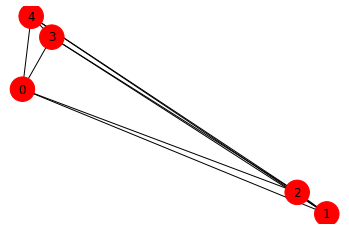

In [8]:
pulsar_coreset = [(w, v) for w, v in zip(coreset_weights, coreset_vectors)]
coreset_points, G, H = kq.gen_coreset_graph(coreset=pulsar_coreset, metric='dot')
kq.plot_coreset_graph(coreset_points, G, twoD=False)
hstr = ''
for term in H:
    hstr += '{:.1e}{} + '.format(term[0], ''.join(term[1]))
hstr = hstr[:-2]
print('The corresponding problem Hamiltonian is:\nH = {}'.format(hstr))

In [ ]:
num_params = 2
init_params = None
opt_params, opt_cost = kq.optimize_qaoa(init_params, num_params, shots, P, G, coupling_map, device=device)

In [11]:
gamma, beta = opt_params

In [13]:
circuit, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=device.configuration().coupling_map)
print(circuit)
initial_layout = [1,0,5,10,11]
print(initial_layout)

[1, 0, 5, 10, 11]


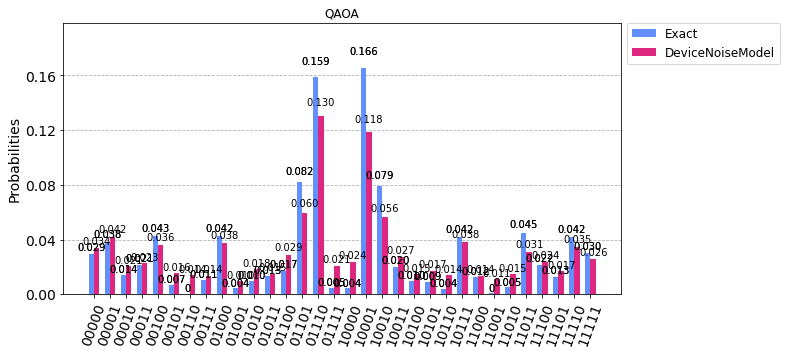

In [18]:
noisy_result = execute(circuit, qasm_simulator, basis_gates=basis_gates, shots=shots, noise_model=noise_model,
                      coupling_map=coupling_map, backend_properties=props, initial_layout=initial_layout).result()
noiseless_results = execute(circuit, qasm_simulator, shots=shots).result()

noisy_counts = kq.reorder_bitstrings(P, len(G.nodes), noisy_result.get_counts())
noiseless_counts = kq.reorder_bitstrings(P, len(G.nodes), noiseless_results.get_counts())
plot_histogram([noiseless_counts, noisy_counts], figsize=(10,5), legend=['Exact', 'DeviceNoiseModel'], title='QAOA')

In [21]:
qpu_job = execute(circuit, backend=device, shots=shots, initial_layout=initial_layout)
job_monitor(qpu_job)
qpu_counts = kq.reorder_bitstrings(P, len(G.nodes), qpu_job.result().get_counts())

Job Status: job has successfully run


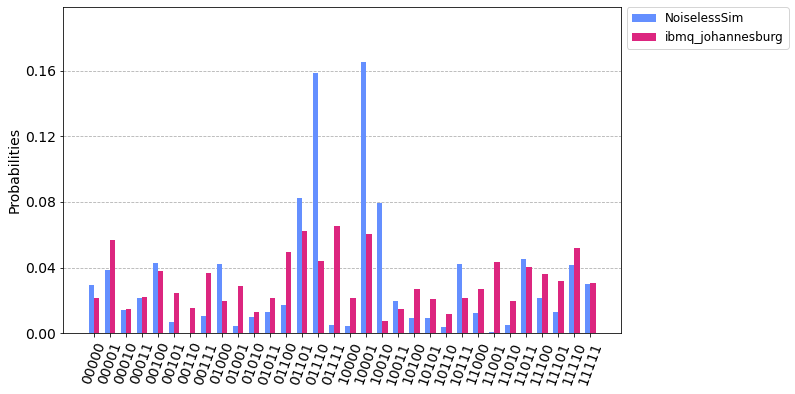

In [24]:
plot_histogram([noiseless_counts, qpu_counts], figsize=(10, 6), legend=['NoiselessSim', 'ibmq_johannesburg'], bar_labels=False)
#fig = plot_histogram([noiseless_counts, noisy_counts, rome_counts], figsize=(10, 6), legend=['NoiselessSim', 'NoisySim', 'IBMQ_Rome'], bar_labels=False)
#fig.set_tight_layout(True)
#fig.savefig('kmeans_qaoa2.png')

In [62]:
partition = '01101'
cluster_centers = kq.compute_centroids(partition, coreset_points)
new_centers = []
for cntr in cluster_centers:
    new_centers.append(np.append(cntr, [0]))
print(new_centers)

mu_plus: [-27.80124908  -7.34955956   0.48116157   1.19557644  -9.0278445
  -4.56623657  -0.185528   -16.88889972]
mu_minus: [ 23.94385248  14.22260333  -0.45750058  -2.48612649 -10.64672214
 -12.91189384   2.19805293  42.86625249]
[array([-27.80124908,  -7.34955956,   0.48116157,   1.19557644,
        -9.0278445 ,  -4.56623657,  -0.185528  , -16.88889972,
         0.        ]), array([ 23.94385248,  14.22260333,  -0.45750058,  -2.48612649,
       -10.64672214, -12.91189384,   2.19805293,  42.86625249,
         0.        ])]


In [63]:
data_vectors = np.load('Datasets/pulsar_data_vectors.npy')
print('{:e}'.format(coreset.get_cost(data_vectors, new_centers)))

5.005598e+08
